In [1]:
from config import *

## region selection

In [2]:
file_sigma='nh3_whole_1arcmin_resz_Sigma_flag_20p_new.fits'
# file_mask='mask_all_coh_core.fits'
file_Tk='nh3_whole_1arcmin_resz_Tkin_flag_tpeak3_20p_new.fits'
# file_esigma='nh3_whole_1arcmin_resz_eSigma_flag_20p_new.fits'
# file_eTk = 'nh3_whole_1arcmin_resz_eTkin_flag_tpeak3_20p_new.fits'

In [3]:
sigma = fits.getdata(file_sigma)
tk,hd = fits.getdata(file_Tk,header=True)

# esigma = fits.getdata(file_esigma)
# etk = fits.getdata(file_eTk)

In [4]:
def setup_plot( fig, cmap='inferno', vmin=0, vmax=10., col_text='Sample (Jy/beam)', 
               do_yso=False, yso_color='white', star_file=None, beam_color='green'):
    """ Comments on the function
    """
    fig.show_colorscale( cmap=cmap, vmin=vmin, vmax=vmax,stretch='linear')
    fig.add_colorbar()
    #fig.colorbar.set_location('top')
    #fig.colorbar.set_axis_label_text(col_text)
    fig.colorbar.show(location='top',axis_label_text=col_text)
    fig.add_beam(color=beam_color)
    distance = 145 *u.pc
    scale=(0.2*u.pc/distance*u.rad).to(u.deg)
    fig.add_scalebar(scale, label='0.2 pc')
#     fig.set_nan_color('0.7')
    fig.ticks.set_color('black')
    fig.add_label( 0.1, 0.1, 'L1688', relative=True,color='k',size=15)
    if do_yso:
        ra = np.loadtxt(star_file,usecols=0)
        dec = np.loadtxt(star_file,usecols=1)
        fig.show_markers(ra,dec,marker='*',s=20,c=yso_color,linewidth=0.7,zorder=4)

/home/spandan/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


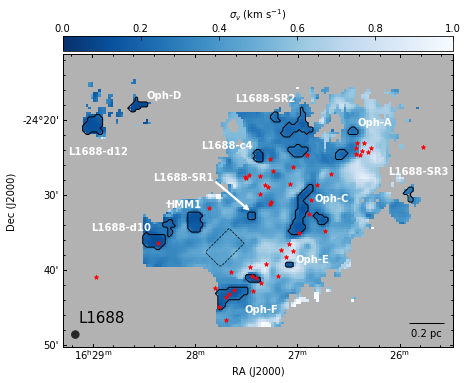

In [9]:
fig = aplfig( file_sigma,figsize=(7,7))
text_color='white'
contour_color='k'
cmap = plt.cm.get_cmap('Blues_r')
cmap.set_bad('0.7')
setup_plot( fig, cmap=cmap, vmin=0, vmax=1, col_text = r'$\sigma_v$ (km s$^{-1}$)',
           do_yso=True, star_file='L1688_protostar_list.txt', yso_color='red', beam_color='0.15')

for r in sort_reg:
    file_mask = r+'_mask.fits'
    fig.show_contour( file_mask, levels=[2.5], colors=contour_color,linewidths=1)

mask_cloud1 = 'mask_mean_cloud_1-0_new3.fits'    
fig.show_contour( mask_cloud1, levels=[1], colors=contour_color,linewidths=0.7, linestyles='dashed')

fig.add_label( 0.09, 0.67, reg_lab['d12'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.26, 0.86, reg_lab['OphD'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.15, 0.41, reg_lab['d10'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.31, 0.49, reg_lab['d9'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.51, 0.13, reg_lab['OphF'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.42, 0.69, reg_lab['c4'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.52, 0.85, reg_lab['top'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.31, 0.58, reg_lab['B_sou'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.64, 0.3, reg_lab['OphE'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.69, 0.51, reg_lab['OphC'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.8, 0.77, reg_lab['OphA'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.91, 0.6, reg_lab['west'], relative=True,color=text_color,size=10,weight='bold')

fig.show_arrows(246.95, -24.47, -0.08, -0.062, width=0.5, head_width=2, head_length=2, color=text_color)

# distance = 138 *u.pc
# scale=(0.2*u.pc/distance*u.rad).to(u.deg)
# fig.add_scalebar(scale, label='0.2 pc')
# fig.savefig('/home/spandan/Desktop/L1688_paper/L1688_region_selection_letter.pdf')


##     